In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc3


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-05-01 16:39:16--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2020-05-01 16:39:16 (5.62 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



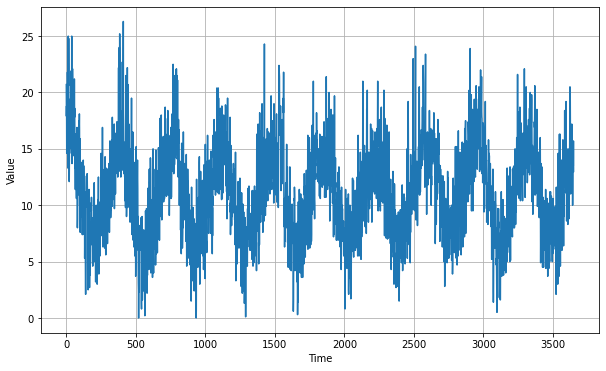

In [0]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 60
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(60, 5, 1, 'causal',
                                                           activation='relu',
                                                           input_shape = [None, 1]),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
                                    tf.keras.layers.Dense(30, activation = 'relu'),
                                    tf.keras.layers.Dense(10, activation = 'relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 38ms/step - loss: 21.0358 - mae: 21.5723 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 43ms/step - loss: 19.8866 - mae: 20.4062 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 44ms/step - loss: 18.1609 - mae: 18.7026 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 42ms/step - loss: 16.2525 - mae: 16.7831 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 44ms/step - loss: 14.2816 - mae: 14.8433 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 45ms/step - loss: 12.5168 - mae: 13.0327 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 45ms/step - loss: 11.0303 - mae: 11.5722 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 46ms/step - loss: 9.9859 - mae: 10.5004 - lr

(1e-08, 0.0001, 0.0, 60.0)

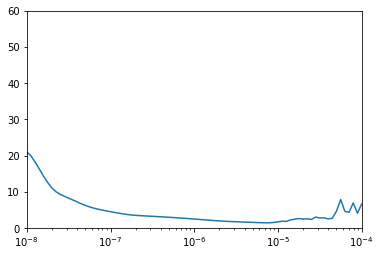

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(60, 5, 1, 'causal',
                                                           activation='relu',
                                                           input_shape = [None, 1]),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
                                    tf.keras.layers.Dense(30, activation = 'relu'),
                                    tf.keras.layers.Dense(10, activation = 'relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*400)
])



optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=200)

Epoch 1/200
25/25 [==============================] - 1s 25ms/step - loss: 6.5815 - mae: 7.1517
Epoch 2/200
25/25 [==============================] - 1s 28ms/step - loss: 2.0729 - mae: 2.5387
Epoch 3/200
25/25 [==============================] - 1s 27ms/step - loss: 1.5531 - mae: 1.9984
Epoch 4/200
25/25 [==============================] - 1s 26ms/step - loss: 1.4325 - mae: 1.8757
Epoch 5/200
25/25 [==============================] - 1s 25ms/step - loss: 1.3661 - mae: 1.8053
Epoch 6/200
25/25 [==============================] - 1s 26ms/step - loss: 1.3086 - mae: 1.7469
Epoch 7/200
25/25 [==============================] - 1s 27ms/step - loss: 1.2645 - mae: 1.7006
Epoch 8/200
25/25 [==============================] - 1s 25ms/step - loss: 1.2250 - mae: 1.6605
Epoch 9/200
25/25 [==============================] - 1s 26ms/step - loss: 1.1941 - mae: 1.6280
Epoch 10/200
25/25 [==============================] - 1s 26ms/step - loss: 1.1649 - mae: 1.5963
Epoch 11/200
25/25 [=============================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

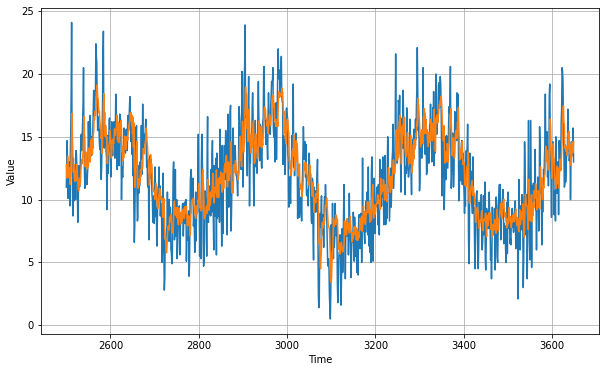

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()


1.9486576

In [0]:
print(rnn_forecast)

[12.7498045 11.716139  12.114471  ... 13.863304  13.746018  14.6221695]
